In [1]:
%load_ext autoreload
%autoreload 2

# Assessing Multicollinearity

In [60]:
"rocket_r"import sys
sys.path.append('../')
import tokamakTK
from tokamakTK import get_ECT_regression, prepare_data, get_pi_matrix, get_condition_number

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from collections import Counter
from scipy.stats import f
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)
path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

plt.rc('font',family = 'serif')

features = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

SyntaxError: invalid syntax (1724210408.py, line 1)

In [77]:
p# Obtained from Optimization

min_subset_ids_6357 = pd.read_csv(path+"R_ids_alpha_0.6357.csv")
min_subset_ids_9998 = pd.read_csv(path+"R_ids_alpha_0.9998.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# Removing Spherical TOKAMAKS
DB5 = DB5[~DB5["TOK"].isin(['START','MAST','NSTX'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label_6357",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_6357.id)].index), "label_6357"] = 1

DB5.insert(loc=2,column="label_9998",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids_9998.id)].index), "label_9998"] = 1

DB5.insert(0, 'intercept', np.ones(len(DB5)))


print(
    "  Subset that decrease alpha-R to 0.6357\n--------\n" +
    f"{ round( (len(min_subset_ids_6357)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_6357)/len(DB5))*100 ,2)  }% did not affect alpha_R" +
    "\n\n\n  Subset that decrease alpha-R to 0.9998\n--------\n" +
    f"{ round( (len(min_subset_ids_9998)/len(DB5))*100     ,2)  }% affected alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids_9998)/len(DB5))*100 ,2)  }% did not affect alpha_R"
)

NameError: name 'p' is not defined

### Functions inside `tokamakTK`

```Python
def prepare_data(data, 
                 columns=['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF'], 
                 add_intercept=True):
    """
    Prepare data such tha the ECT regression can be assessed
    """
    data = data[columns]
    data = data.apply(np.abs).apply(np.log)
    if add_intercept:
        data = sm.add_constant(data)
    return data

def scale_data(df, centered=False):
    if centered:
        df = df - df.describe().loc["mean"]
    X  = (df / df.apply(lambda x: np.linalg.norm(x))).to_numpy()
    return X

def get_condition_number(X):
    # Get Singular Values
    _,S,_ = np.linalg.svd(X)
    # Return condition index
    return max(S)/min(S)

def get_condition_index(X):
    # Get Singular Values
    _,S,_ = np.linalg.svd( X )
    # Return condition indexes
    return max(S)/S

def get_pi_matrix(X, features, scale=True):
    if scale:
        X = scale_data(X)
        
    U,D,VT = np.linalg.svd( X ) # Transpose of V ----> ask Joe.
    V_sq   = np.square(VT.T); mu_sq = np.square(D)

    φ_kj   = np.zeros((len(features)+1,len(features)+1))
    φ_k    = np.zeros(len(features)+1)
    pi_jk  = np.zeros((len(features)+1,len(features)+1))

    for k in range(len(features)):
        φ_kj[k,:] = V_sq[k,:] / mu_sq
        φ_k[k] = φ_kj[k,:].sum()
        pi_jk[:,k]  = φ_kj[k,:] / φ_k[k]

    # Pi-Matrix (Variance Decomposition)
    Π = pd.DataFrame(pi_jk, 
                     index=[f"μ{i}" for i in range(len(features)+1)], 
                     columns=["intrcp"]+features) 
    return Π
```

In [78]:
all_cases = [prepare_data(DB2.copy(), features),  #0 DB2
             prepare_data(DB5.copy(), features),  #1 DB2
             prepare_data(DB5[DB5.label_6357.isin([1]) | DB5.id.isin(DB2.id.values)], features),  #2 Decreasing DB5 ~ 0.64
             prepare_data(DB5[DB5.label_6357.isin([0])], features),                               #3 Unaffected DB5 ~ 0.64
             prepare_data(DB5[DB5.label_9998.isin([1]) | DB5.id.isin(DB2.id.values)], features),  #4 Decreasing DB5 ~ 0.99
             prepare_data(DB5[DB5.label_9998.isin([0])], features)                                #5 Unaffected DB5 ~ 0.99
]

In [79]:
all_cases[0]

,const,NEL,IP,BT,PLTH,RGEO,KAREA,EPS,MEFF
0,1.0,1.332102,-1.217734,0.790728,0.625938,0.527093,-0.025523,-1.418447,0.405465
1,1.0,1.317480,-1.220102,0.790728,0.705076,0.521172,-0.027988,-1.409604,0.405465
2,1.0,1.226712,-1.213686,0.790728,0.123986,0.526502,-0.010556,-1.432100,0.405465
3,1.0,1.328400,-1.217734,0.790728,0.319181,0.526502,-0.025933,-1.417369,0.405465
4,1.0,1.347294,-1.223495,0.790274,0.709513,0.521766,-0.031387,-1.406800,0.405465
...,...,...,...,...,...,...,...,...,...
1305,1.0,1.370165,-0.973390,0.098940,0.506215,0.336472,0.014889,-1.252763,0.693147
1306,1.0,1.484328,-1.037047,0.051643,0.536493,0.336472,0.014889,-1.203973,0.693147
1307,1.0,1.436987,-1.284821,0.049742,0.366031,0.336472,0.012916,-1.203973,0.693147
1308,1.0,1.301009,-1.369241,0.049742,0.123986,0.336472,0.012916,-1.203973,0.693147


In [80]:
Π = [get_pi_matrix(x, features, scale=True) for x in all_cases]

CI (DB2): [ 1.    2.28  5.28  5.8  10.52 11.14 17.7  33.15 46.7 ]
CI (DB5): [ 1.    2.72  5.43  7.1  12.13 14.31 17.68 29.59 55.46]


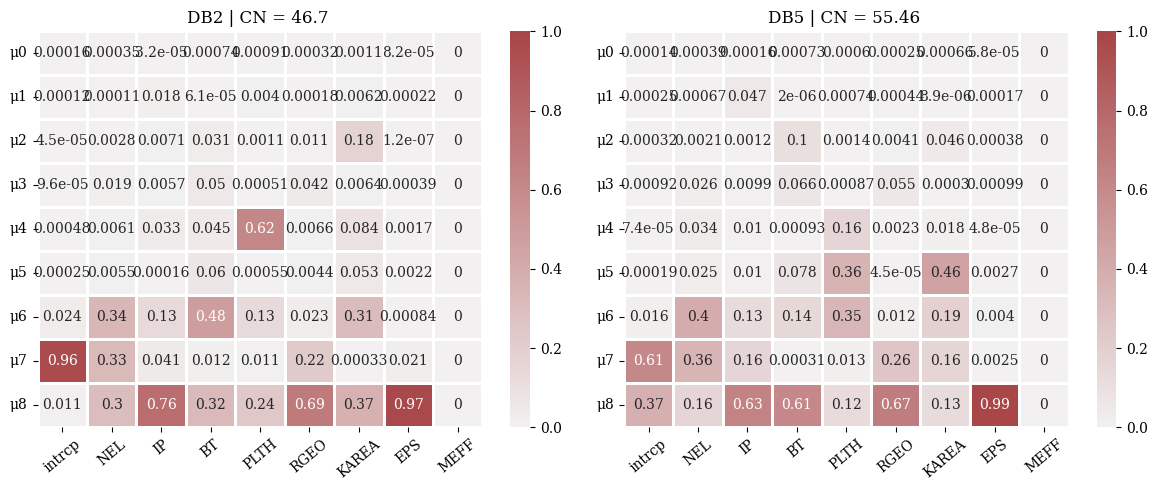

In [81]:
print(f"CI (DB2): {np.round(tokamakTK.get_condition_index(all_cases[0]),2)}")
print(f"CI (DB5): {np.round(tokamakTK.get_condition_index(all_cases[1]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting subplot 1
sns.heatmap(Π[0], vmin=0, vmax=1, linecolor="white", annot=True, linewidth=0.73, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"DB2 | CN = {round(get_condition_number(all_cases[0]),2)} ")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40)

# Plotting subplot 2
sns.heatmap(Π[1], vmin=0, vmax=1, linecolor="white", annot=True, linewidth=0.73, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"DB5 | CN = {round(get_condition_number(all_cases[1]),2)} ")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40)

# Adjust the layout and spacing between subplots
plt.tight_layout()

Case: alpha-R 0.6357
CI (DB5 | d)label=1 + DB2: [ 1.    2.46  5.11  6.53 11.45 12.55 16.42 26.79 46.81]
CI (DB5 | u): [ 1.    2.67  5.44  7.02 11.81 13.56 17.7  29.45 57.2 ]


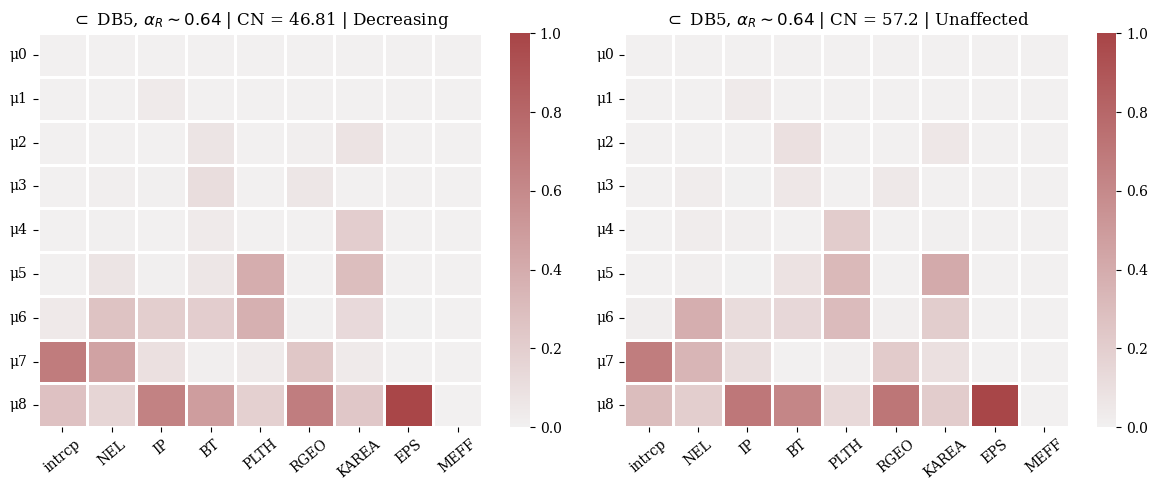

In [82]:
print("Case: alpha-R 0.6357")
print(f"CI (DB5 | d)label=1 + DB2: {np.round(tokamakTK.get_condition_index(all_cases[2]),2)}")
print(f"CI (DB5 | u): {np.round(tokamakTK.get_condition_index(all_cases[3]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plotting subplot 1
sns.heatmap(Π[2], vmin=0, vmax=1, linecolor="white", linewidth=0.73, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"$\\subset$ DB5, $\\alpha_R \\sim 0.64$ | CN = {round(get_condition_number(all_cases[2]),2)} | Decreasing")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40)

# Plotting subplot 2
sns.heatmap(Π[3], vmin=0, vmax=1, linecolor="white", linewidth=0.73, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"$\\subset$ DB5, $\\alpha_R \\sim 0.64$ | CN = {round(get_condition_number(all_cases[3]),2)} | Unaffected")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40)

# Adjust the layout and spacing between subplots
plt.tight_layout()

Case: alpha-R 0.9998
CI (DB5 | d): [ 1.    2.36  5.32  6.16 10.86 11.68 16.47 27.23 46.05]
CI (DB5 | u): [ 1.    2.7   5.4   7.1  12.05 14.01 17.61 29.45 55.79]


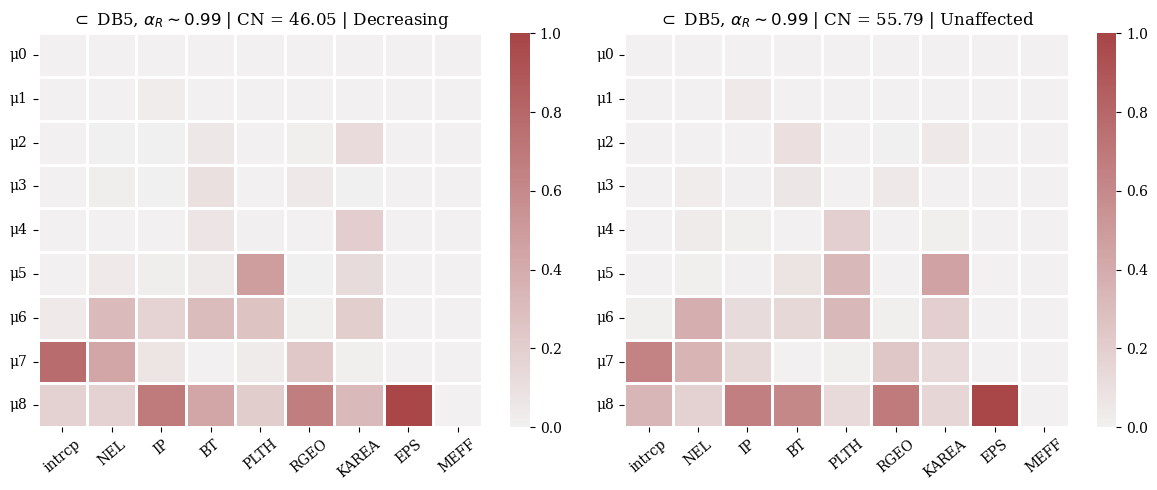

In [67]:
print("Case: alpha-R 0.9998")
print(f"CI (DB5 | d): {np.round(tokamakTK.get_condition_index(all_cases[4]),2)}")
print(f"CI (DB5 | u): {np.round(tokamakTK.get_condition_index(all_cases[5]),2)}")
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
label=1 + DB2
# Plotting subplot 1
sns.heatmap(Π[4], vmin=0, vmax=1, linecolor="white", linewidth=0.73, ax=ax1, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax1.set_title(f"$\\subset$ DB5, $\\alpha_R \\sim 0.99$ | CN = {round(get_condition_number(all_cases[4]),2)} | Decreasing")
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40)

# Plotting subplot 2
sns.heatmap(Π[5], vmin=0, vmax=1, linecolor="white", linewidth=0.73, ax=ax2, cmap=sns.color_palette("light:#A84547", as_cmap=True))
ax2.set_title(f"$\\subset$ DB5, $\\alpha_R \\sim 0.99$ | CN = {round(get_condition_number(all_cases[5]),2)} | Unaffected")
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40)

# Adjust the layout and spacing between subplots
plt.tight_layout()

## Variance Inflation Factor (VIF) and Tolerance

The Variation Inflation Factor (VIF) is a measure of multicollinearity in a linear regression model. It quantifies the degree to which the variance of the estimated regression coefficient is inflated due to collinearity in the predictors.

"One recommendation is that **if VIF is greater than 5**, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this." [[statsmodels]](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

$$
    \text{VIF}_j = \frac{1}{1-R^2_j}.
$$

With $R^2_j$ being the coefficient of determination for the regression of $x_j$ on the remaining variables; namely, 

$$
    R^2 = 1 - \frac{RSS}{TSS}.
$$

With $RSS$ being the sum of squares of residuals; and, $TSS$ the total sum of squares;

$$
    SSR = \sum_i\left( \hat{y} - \bar{y} \right)^2; \quad \text{and} \quad TSS = \sum_i\left( y - \bar{y} \right)^2
$$

**Tolerance** is the inverse of VIF and relates to the proportion of variance in a predictor variable. A **tolerance value less than 0.1** is generally considered to be indicative of problematic multicollinearity.|

In [68]:
all_cases = [prepare_data(DB2.copy(), features, False),  #0 DB2
             prepare_data(DB5.copy(), features, False),  #1 DB2
             prepare_data(DB5[DB5.label_6357.isin([1]) | DB5.id.isin(DB2.id.values)], features, False),  #2 Decreasing DB5 ~ 0.64
             prepare_data(DB5[DB5.label_6357.isin([0])], features, False),                               #3 Unaffected DB5 ~ 0.64
             prepare_data(DB5[DB5.label_9998.isin([1]) | DB5.id.isin(DB2.id.values)], features, False),  #4 Decreasing DB5 ~ 0.99
             prepare_data(DB5[DB5.label_9998.isin([0])], features, False)                                #5 Unaffected DB5 ~ 0.99
]

all_cases = [tokamakTK.scale_data(case, add_intercept=True) for case in all_cases]

In [72]:
VIF = pd.DataFrame()
for c,case in enumerate(all_cases):
    VIF[f"C{c}"]=[variance_inflation_factor(case.values, f) for f in range(len(features)+1)]
VIF.index = ["const"] + features
VIF.columns = ["DB2", "DB5", "DB5_0.64d", "DB5_0.64u", "DB5_0.99d", "DB5_0.99u"]

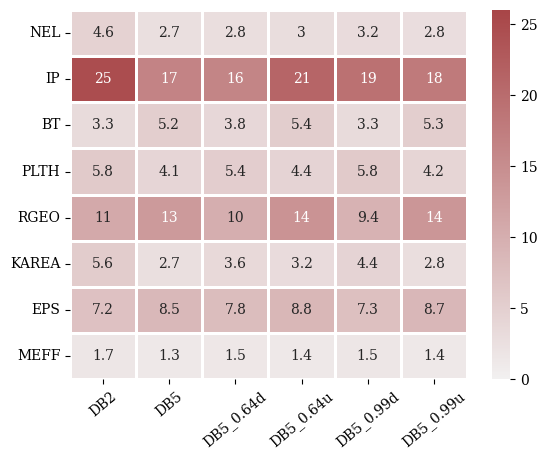

In [75]:
ax = sns.heatmap(VIF.loc[features], vmin=0, vmax=26, annot=True,
                 cmap=sns.color_palette("light:#A84547", as_cmap=True), linecolor="white", linewidth=0.73)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40);
#,plt.savefig(fig_path+"VIF_all_datasets.pdf", format="pdf", dpi=800, bbox_inches='tight');